In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

In [4]:
data_dir = pathlib.Path("C:/Users/eberz/Documents/Projects for fun/Bonsai NN/most_popular_trees")

In [5]:
print(data_dir)

C:\Users\eberz\Documents\Projects for fun\Bonsai NN\most_popular_trees


In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3222


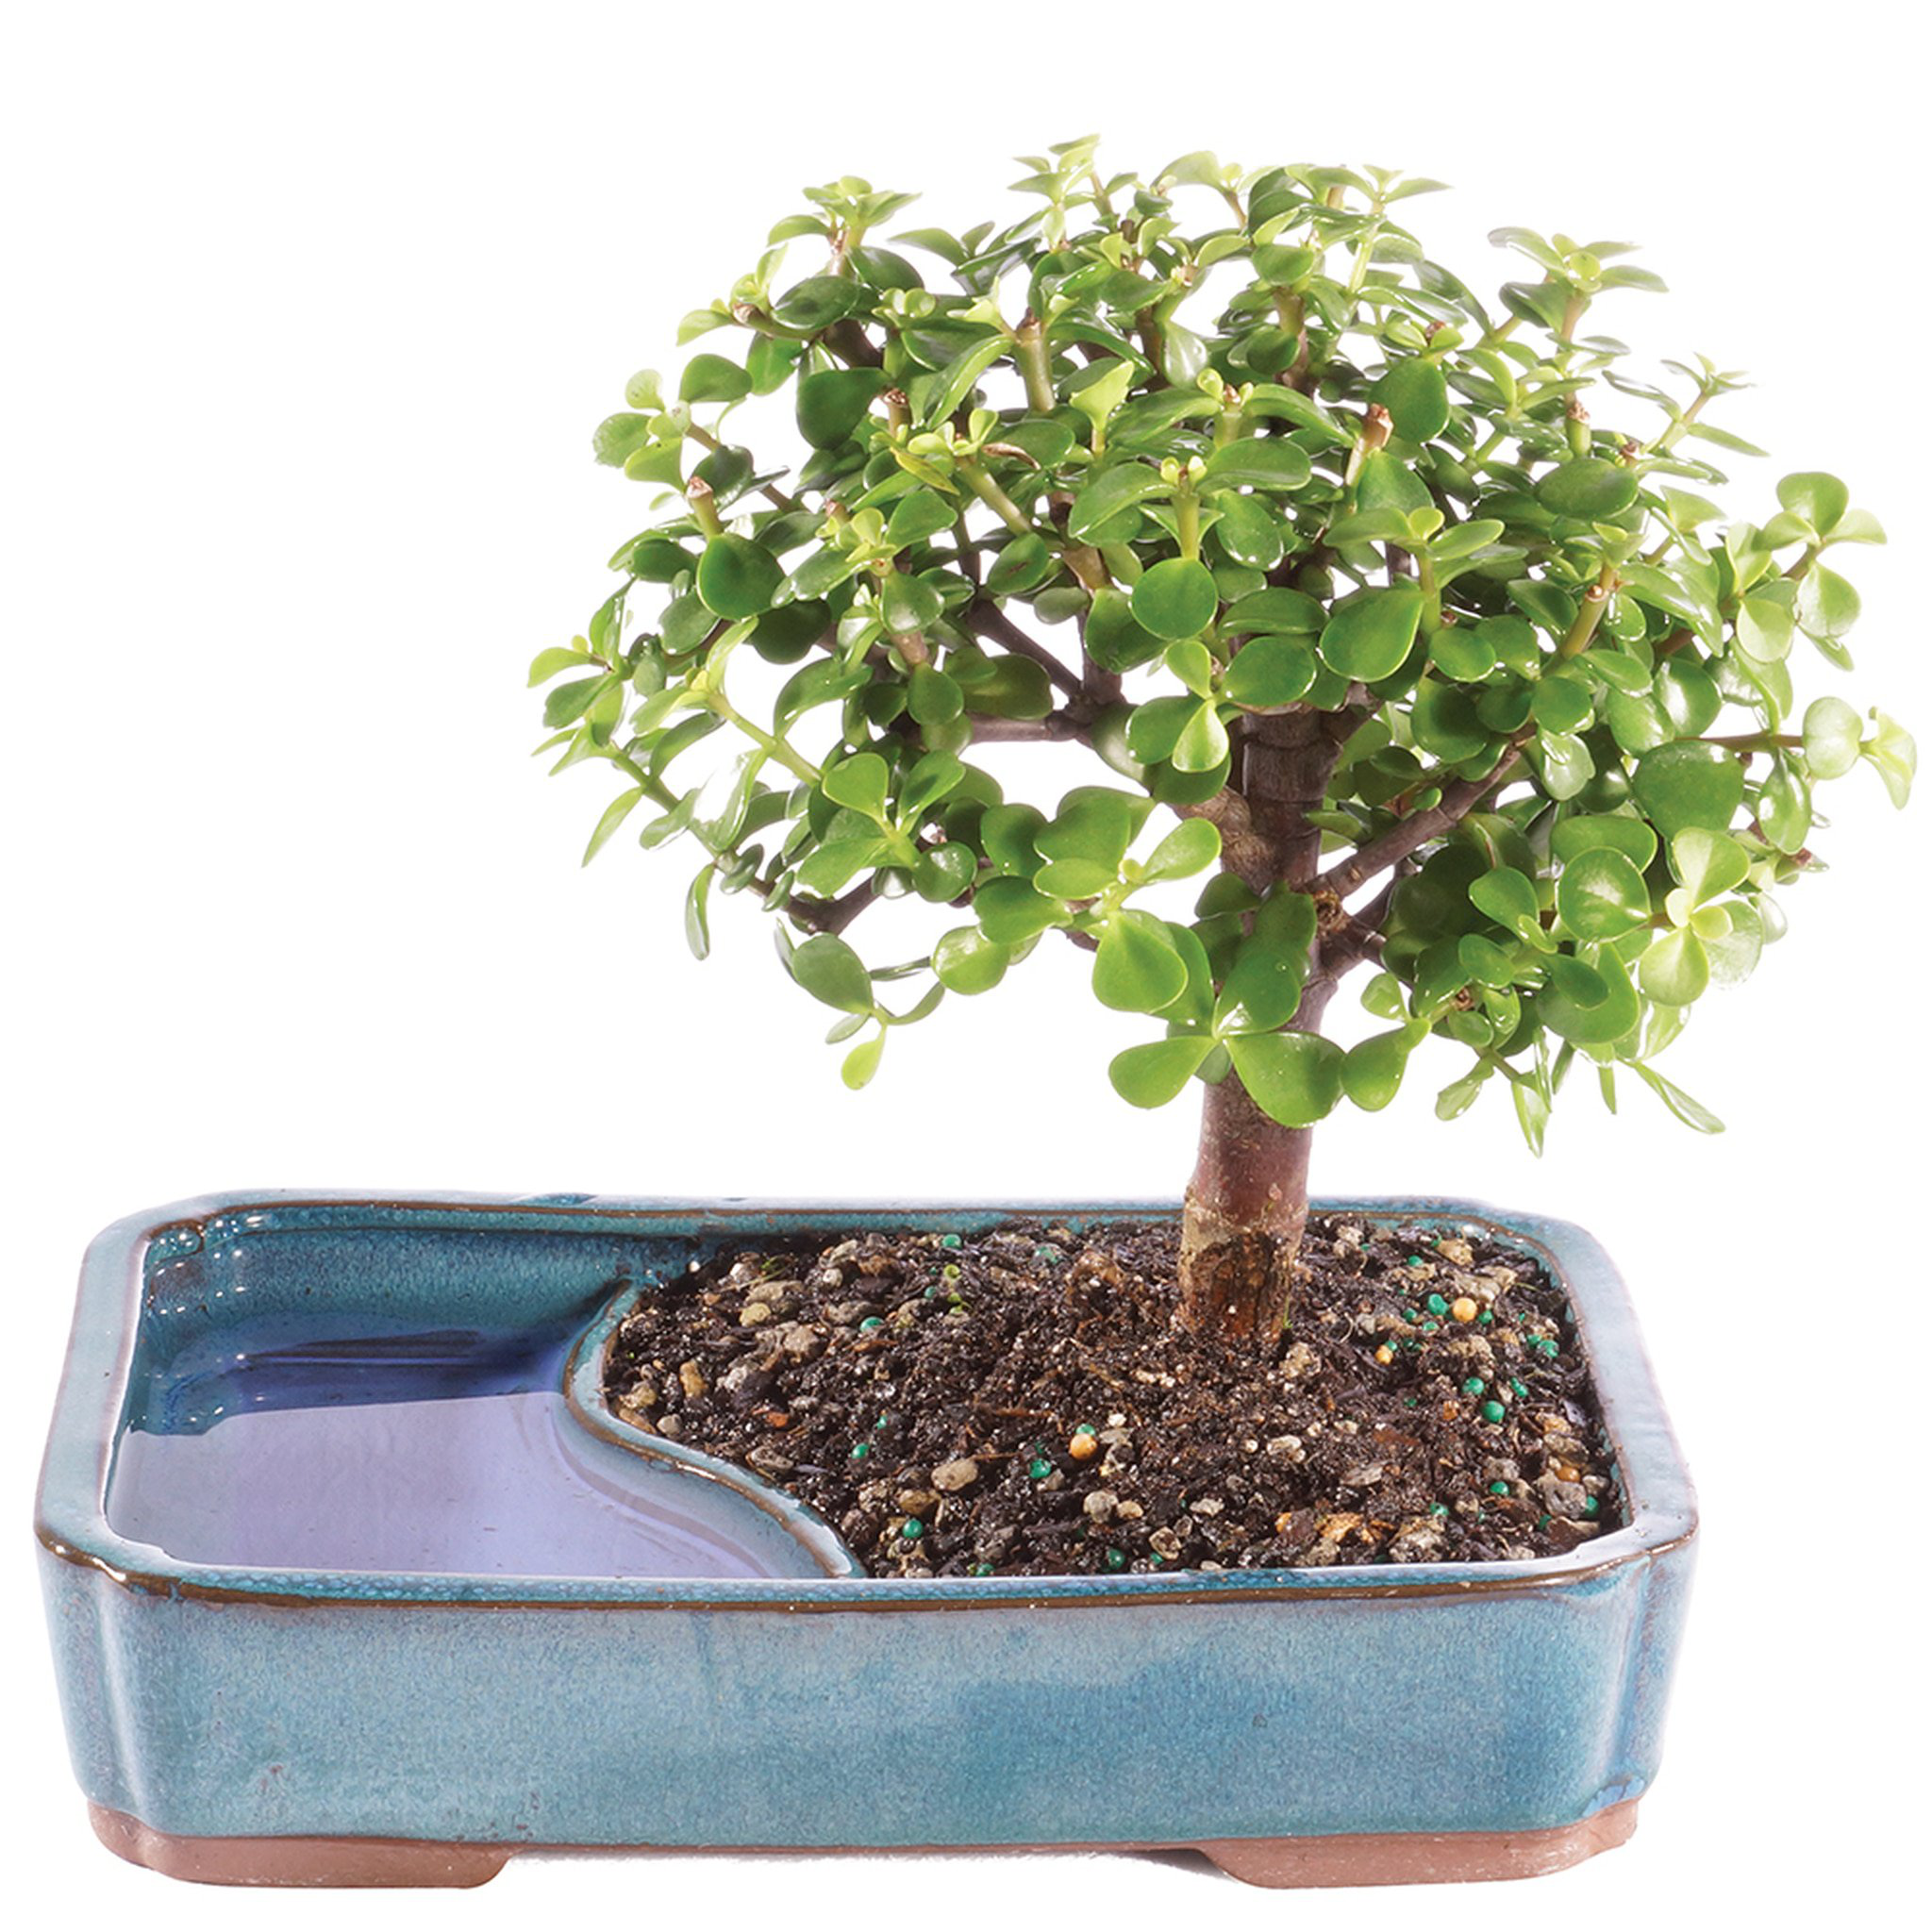

In [7]:
jades = list(data_dir.glob('dwarf_jade_bonsai/*'))
PIL.Image.open(str(jades[0]))


In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3222 files belonging to 8 classes.
Using 2578 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3222 files belonging to 8 classes.
Using 644 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['brazilian_rain_bonsai_tree', 'chinese_elm_bonsai', 'dwarf_jade_bonsai', 'ficus_bonsai', 'fukien_tea_bonsai', 'ginko_bonsai', 'juniper_bonsai', 'redwood_bonsai']


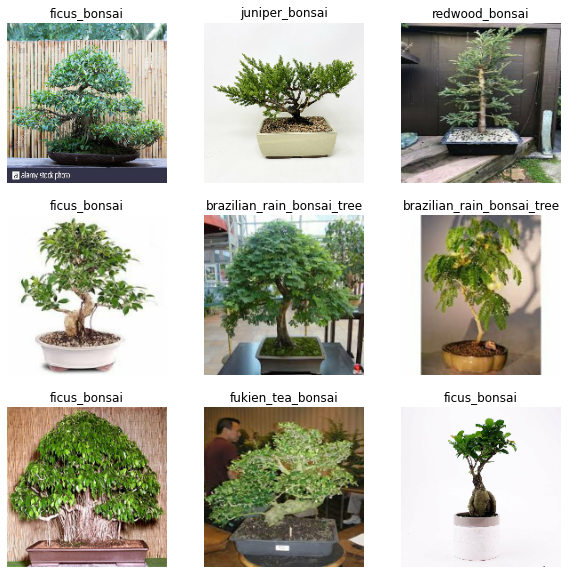

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.9653177


In [19]:
num_classes = 8

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [183]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [184]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_16 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 22, 22, 64)      

In [185]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
81/81 [==============================] - 21s 261ms/step - loss: 2.1608 - accuracy: 0.1896 - val_loss: 1.9460 - val_accuracy: 0.2655
Epoch 2/10
81/81 [==============================] - 20s 245ms/step - loss: 1.9003 - accuracy: 0.2888 - val_loss: 1.8182 - val_accuracy: 0.3432
Epoch 3/10
81/81 [==============================] - 20s 241ms/step - loss: 1.5529 - accuracy: 0.4598 - val_loss: 1.8620 - val_accuracy: 0.3742
Epoch 4/10
81/81 [==============================] - 20s 243ms/step - loss: 1.1219 - accuracy: 0.6288 - val_loss: 1.7119 - val_accuracy: 0.4674
Epoch 5/10
81/81 [==============================] - 20s 243ms/step - loss: 0.6603 - accuracy: 0.7913 - val_loss: 2.1213 - val_accuracy: 0.5248
Epoch 6/10
81/81 [==============================] - 20s 242ms/step - loss: 0.2742 - accuracy: 0.9267 - val_loss: 2.3532 - val_accuracy: 0.5357
Epoch 7/10
81/81 [==============================] - 20s 243ms/step - loss: 0.1457 - accuracy: 0.9674 - val_loss: 2.8218 - val_accuracy: 0.5357

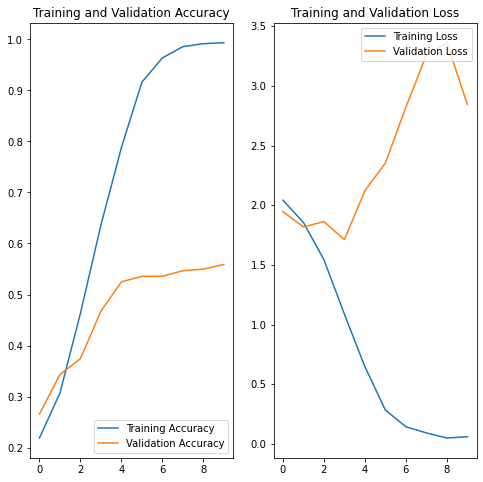

In [186]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [187]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),

  ]
)

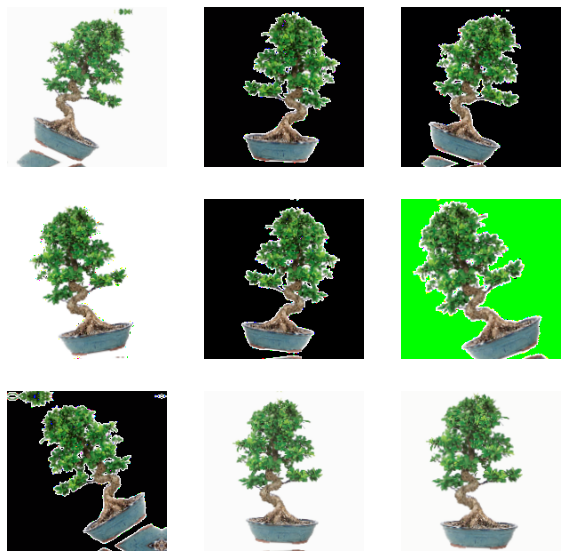

In [188]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [196]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [197]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [198]:
model.summary()


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_17 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_18 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 41, 41, 64)      

In [202]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
81/81 [==============================] - 20s 251ms/step - loss: 1.2243 - accuracy: 0.5628 - val_loss: 1.6918 - val_accuracy: 0.4410
Epoch 2/50
81/81 [==============================] - 20s 252ms/step - loss: 1.1780 - accuracy: 0.5853 - val_loss: 1.6311 - val_accuracy: 0.4705
Epoch 3/50
81/81 [==============================] - 20s 250ms/step - loss: 1.1402 - accuracy: 0.5985 - val_loss: 1.6799 - val_accuracy: 0.4938
Epoch 4/50
81/81 [==============================] - 20s 250ms/step - loss: 1.1488 - accuracy: 0.6086 - val_loss: 1.6551 - val_accuracy: 0.4814
Epoch 5/50
81/81 [==============================] - 20s 249ms/step - loss: 1.0749 - accuracy: 0.6354 - val_loss: 1.6397 - val_accuracy: 0.4907
Epoch 6/50
81/81 [==============================] - 20s 251ms/step - loss: 1.0701 - accuracy: 0.6307 - val_loss: 1.7137 - val_accuracy: 0.4938
Epoch 7/50
81/81 [==============================] - 20s 250ms/step - loss: 1.0450 - accuracy: 0.6338 - val_loss: 1.5567 - val_accuracy: 0.5264

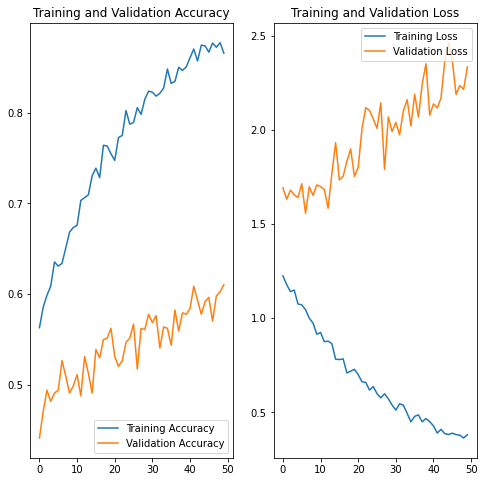

In [203]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [204]:
test_path = pathlib.Path("C:/Users/eberz/Documents/Projects for fun/Bonsai NN/most_popular_trees/juniper_bonsai/2ada5bbedf.jpg")

img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image is most likely a {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image is most likely a juniper_bonsai with a 99.75 percent confidence.


In [9]:
from kerastuner import HyperModel


class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(
            Conv2D(
                filters=16,
                kernel_size=3,
                activation='relu',
                input_shape=self.input_shape
            )
        )
        model.add(
            Conv2D(
                filters=16,
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )
        model.add(
            Conv2D(
                filters=32,
                kernel_size=3,
                activation='relu'
            )
        )
        model.add(
            Conv2D(
                filters=hp.Choice(
                    'num_filters',
                    values=[32, 64],
                    default=64,
                ),
                activation='relu',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )
        model.add(Flatten())
        model.add(
            Dense(
                units=hp.Int(
                    'units',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=128
                ),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                )
            )
        )
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_3',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=(img_height, img_width, 3), num_classes=8)

In [24]:
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)

INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

model = keras.Sequential()
model.add(
    Conv2D(
        filters=16,
        kernel_size=3,
        activation='relu',
        input_shape=INPUT_SHAPE
    )
)
model.add(Conv2D(16, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(rate=0.25))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [25]:
from kerastuner.tuners import Hyperband

HYPERBAND_MAX_EPOCHS = 40
EXECUTION_PER_TRIAL = 2
SEED = 42

tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_accuracy',
    seed=SEED,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory=data_dir,
    project_name='Bonsai_Classifier'
)


In [26]:
from kerastuner.tuners import RandomSearch

MAX_TRIALS = 20

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory=data_dir,
    project_name='Bonsai_Classifier'
)


In [27]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_3 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [43]:
from kerastuner import HyperModel
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D


class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(
            Conv2D(
                filters=16,
                kernel_size=3,
                activation="relu",
                input_shape=self.input_shape,
            )
        )
        model.add(Conv2D(filters=16, activation="relu", kernel_size=3))
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(
                rate=hp.Float(
                    "dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05,
                )
            )
        )
        model.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
        model.add(
            Conv2D(
                filters=hp.Choice("num_filters", values=[32, 64], default=64,),
                activation="relu",
                kernel_size=3,
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(
                rate=hp.Float(
                    "dropout_2", min_value=0.0, max_value=0.5, default=0.25, step=0.05,
                )
            )
        )
        model.add(Flatten())
        model.add(
            Dense(
                units=hp.Int(
                    "units", min_value=32, max_value=512, step=32, default=128
                ),
                activation=hp.Choice(
                    "dense_activation",
                    values=["relu", "tanh", "sigmoid"],
                    default="relu",
                ),
            )
        )
        model.add(
            Dropout(
                rate=hp.Float(
                    "dropout_3", min_value=0.0, max_value=0.5, default=0.25, step=0.05
                )
            )
        )
        model.add(Dense(self.num_classes, activation="softmax"))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    "learning_rate",
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling="LOG",
                    default=1e-3,
                )
            ),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model
